In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow import keras

In [2]:
model = ResNet50(weights='imagenet',
                include_top=False,
                input_shape=(224, 224, 3),
                pooling='max')

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2)

In [4]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
    return file_list

In [5]:
root_dir = './cat_train_images'
filenames = sorted(get_file_list(root_dir))

TRAIN_SAMPLES = len(filenames)
NUM_CLASSES = 67
IMG_WIDTH, IMG_HEIGHT = 224, 224
batch_size=64

In [6]:
train_generator = train_datagen.flow_from_directory(root_dir,
                                                   target_size=(IMG_WIDTH,
                                                               IMG_HEIGHT),
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   seed=12345,
                                                   class_mode='categorical')

Found 126599 images belonging to 67 classes.


In [7]:
filenames

['./cat_train_images\\Abyssinian\\12136161_252.jpg',
 './cat_train_images\\Abyssinian\\13743713_251.jpg',
 './cat_train_images\\Abyssinian\\14092337_250.jpg',
 './cat_train_images\\Abyssinian\\14475392_248.jpg',
 './cat_train_images\\Abyssinian\\16485182_247.jpg',
 './cat_train_images\\Abyssinian\\16734355_246.jpg',
 './cat_train_images\\Abyssinian\\17041760_245.jpg',
 './cat_train_images\\Abyssinian\\17060240_244.jpg',
 './cat_train_images\\Abyssinian\\17361971_242.jpg',
 './cat_train_images\\Abyssinian\\17361980_243.jpg',
 './cat_train_images\\Abyssinian\\17704905_241.jpg',
 './cat_train_images\\Abyssinian\\17870903_240.jpg',
 './cat_train_images\\Abyssinian\\35021741_239.jpg',
 './cat_train_images\\Abyssinian\\35374431_238.jpg',
 './cat_train_images\\Abyssinian\\36865042_237.jpg',
 './cat_train_images\\Abyssinian\\37673424_236.jpg',
 './cat_train_images\\Abyssinian\\37771828_235.jpg',
 './cat_train_images\\Abyssinian\\37865356_234.jpg',
 './cat_train_images\\Abyssinian\\37942697_233

In [8]:
def model_maker():
    base_model = ResNet50(include_top=False,
                         input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [9]:
model_finetuned = model_maker()
# model_finetuned.compile(loss='categorical_crossentropy',
#                        optimizer=tf.keras.optimizers.Adam(0.001),
#                        metrics=['acc'])
# model_finetuned.fit_generator(
#     train_generator,
#     steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / batch_size),
#     epochs=10
# )

In [10]:
model_finetuned.save('./model-finetuned.h5')

In [11]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

generator = datagen.flow_from_directory('./cat_test_images',
                                       target_size=(224, 224),
                                       batch_size=batch_size,
                                       class_mode=None,
                                       shuffle=False)

num_images = len(generator.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

Found 0 images belonging to 0 classes.


In [12]:
# start_time = time.time()
# feature_list_finetuned = []
# feature_list_finetuned = model_finetuned.predict_generator(generator, num_epochs)
# end_time = time.time()

# for i, features_finetuned in enumerate(feature_list_finetuned):
#     feature_list_finetuned[i] = features_finetuned / norm(features_finetuned)

# feature_list = feature_list_finetuned.reshape(num_images, -1)

# print("Num images = ", len(generator.classes))
# print("Shape of feature_list = ", feature_list.shape)
# print("Time taken in sec = ", end_time - start_time)

In [13]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,
                        target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [14]:
filenames2 = sorted(get_file_list('./cat_test_images'))
filenames2

['./cat_test_images\\jjokgo1.jpg',
 './cat_test_images\\jjokgo2.jpg',
 './cat_test_images\\jjokgo3.jpg',
 './cat_test_images\\jjokgo4.jpg',
 './cat_test_images\\jjokgo5.jpg',
 './cat_test_images\\mango1.jpg',
 './cat_test_images\\mango2.jpg',
 './cat_test_images\\mango3.jpg',
 './cat_test_images\\mango4.jpg',
 './cat_test_images\\mango5.jpg',
 './cat_test_images\\sabum1.jpg',
 './cat_test_images\\sabum2.jpg',
 './cat_test_images\\sabum3.jpg',
 './cat_test_images\\sabum4.jpg',
 './cat_test_images\\sabum5.jpg',
 './cat_test_images\\samsak1.jpg',
 './cat_test_images\\samsak2.jpg',
 './cat_test_images\\samsak3.jpg',
 './cat_test_images\\samsak4.jpg',
 './cat_test_images\\samsak5.jpg',
 './cat_test_images\\sango1.jpg',
 './cat_test_images\\sango2.jpg',
 './cat_test_images\\sango3.jpg',
 './cat_test_images\\sango4.jpg',
 './cat_test_images\\sango5.jpg',
 './cat_test_images\\yuksi1.jpg',
 './cat_test_images\\yuksi2.jpg',
 './cat_test_images\\yuksi3.jpg',
 './cat_test_images\\yuksi4.jpg',
 './

In [15]:
model_finetuned = keras.models.load_model("./model-finetuned-210102.h5")

model_finetuned.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 67)                4355      
Total params: 23,723,203
Trainable params: 135,491
Non-trainable params: 23,587,712
_________________________________________

In [16]:
result =  []

for filename in filenames2:
    result.append(extract_features(filename, model_finetuned))
    
result[0]

array([4.3225237e-03, 2.1495441e-02, 1.0833467e-03, 9.7189702e-02,
       2.8037675e-06, 3.7429677e-06, 2.0519669e-06, 1.7610933e-01,
       4.9254112e-07, 5.7778077e-05, 7.4176779e-03, 3.4635268e-05,
       3.3948749e-07, 2.9592915e-02, 6.2968854e-07, 6.7519172e-06,
       8.9617779e-06, 3.2050383e-07, 5.0171633e-04, 1.5747958e-08,
       3.6013851e-04, 2.3105342e-02, 8.8873152e-03, 1.1512843e-02,
       3.3840992e-02, 9.4399273e-01, 8.4289173e-03, 2.0895083e-03,
       2.9046617e-02, 2.0488180e-05, 2.3886805e-06, 1.8774859e-04,
       1.3237419e-06, 5.2442660e-06, 9.1154448e-07, 8.5272547e-03,
       4.0919796e-02, 1.3987757e-03, 3.7422005e-06, 1.1463453e-03,
       2.0773525e-03, 1.2139602e-06, 1.8884265e-03, 2.9121590e-04,
       3.2610445e-05, 1.3061676e-03, 1.8532754e-05, 1.3290839e-04,
       1.5492592e-04, 3.0409198e-03, 1.0626209e-05, 1.0583560e-03,
       1.7211569e-04, 1.5201388e-03, 6.6314342e-06, 2.0359522e-04,
       1.2727140e-05, 6.5544888e-04, 1.4763510e-01, 1.5569042e

In [17]:
pickle.dump(
    result,
    open('./features.pickle', 'wb')
)

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [19]:
from IPython.display import Image, display

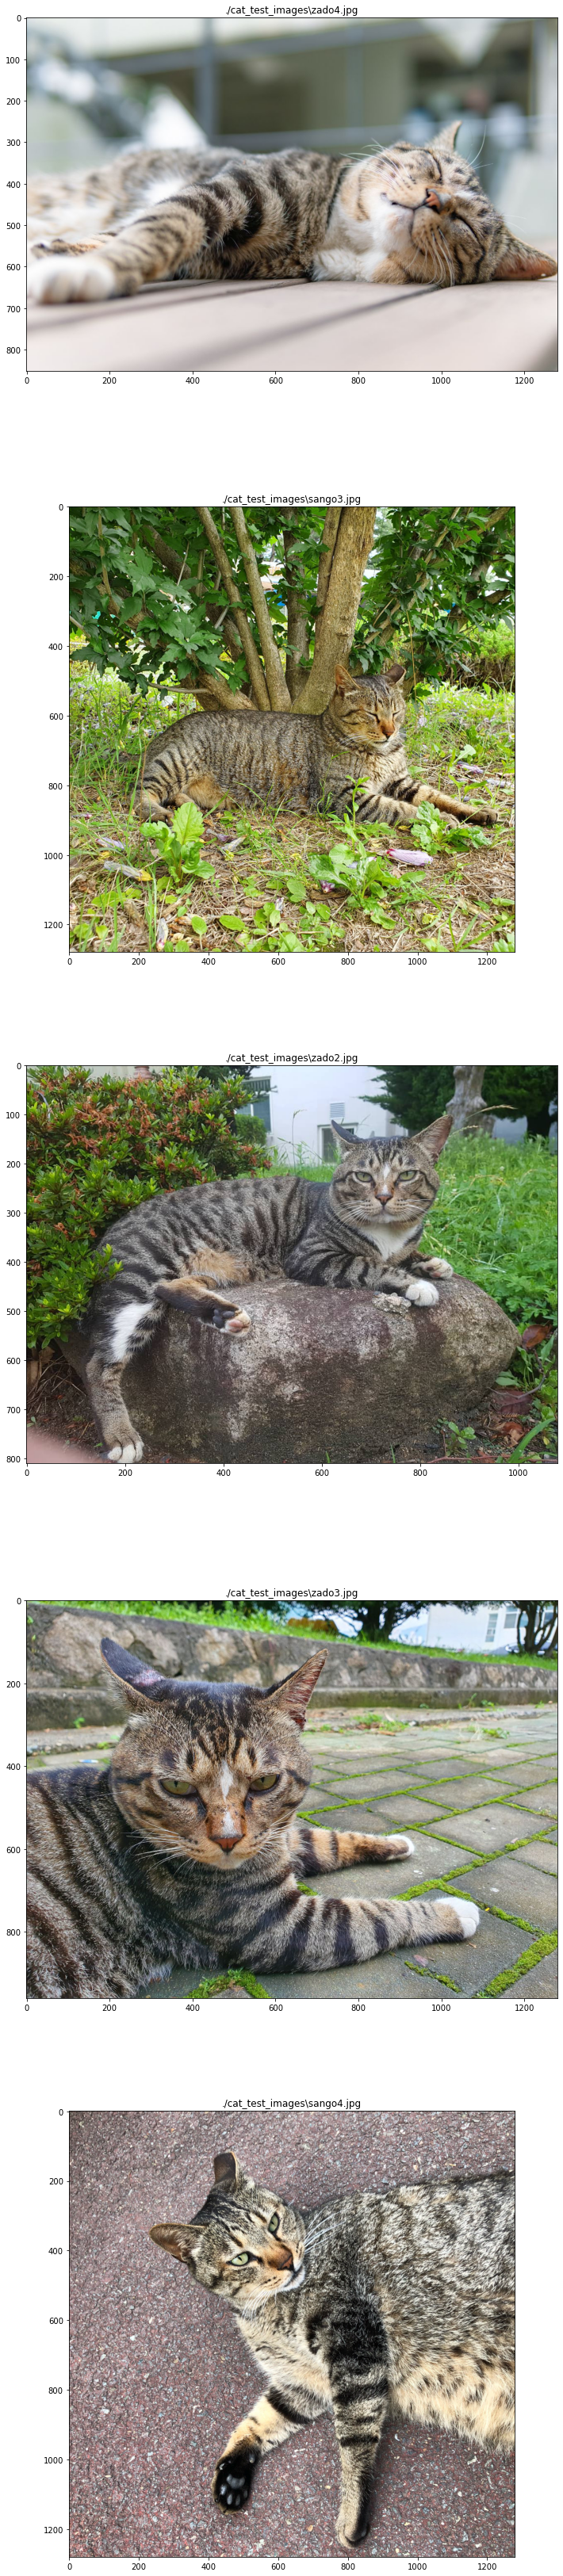

In [20]:
result =  []

for filename in filenames2:
    result.append(extract_features(filename, model_finetuned))
    

neighbors = NearestNeighbors(n_neighbors=5,
                            algorithm='brute',
                            metric='euclidean').fit(result)

fig = plt.figure(figsize=(12, 60))
test_num = 33
j = 1

for i in neighbors.kneighbors([result[test_num]], return_distance=False)[0]:
    ax = fig.add_subplot(5, 1, j)
    j += 1
#     print(filenames2[i])
    ax.set_title(filenames2[i])
    plt_img = mpimg.imread(filenames2[i])
    imgplot = plt.imshow(plt_img)
#     display(Image(filename=filenames2[i]))
    plt.imshow(mpimg.imread(filenames2[i]))

In [21]:
m = keras.models.load_model("./resnetModel.h5")

In [22]:
m.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [23]:
print(extract_features(filenames2[0], m))

[0.01653759 0.01314684 0.01209801 ... 0.00335417 0.03012716 0.0137757 ]


In [24]:
result =  []

for filename in filenames2:
    result.append(extract_features(filename, m))
    
len(result[0])

2048

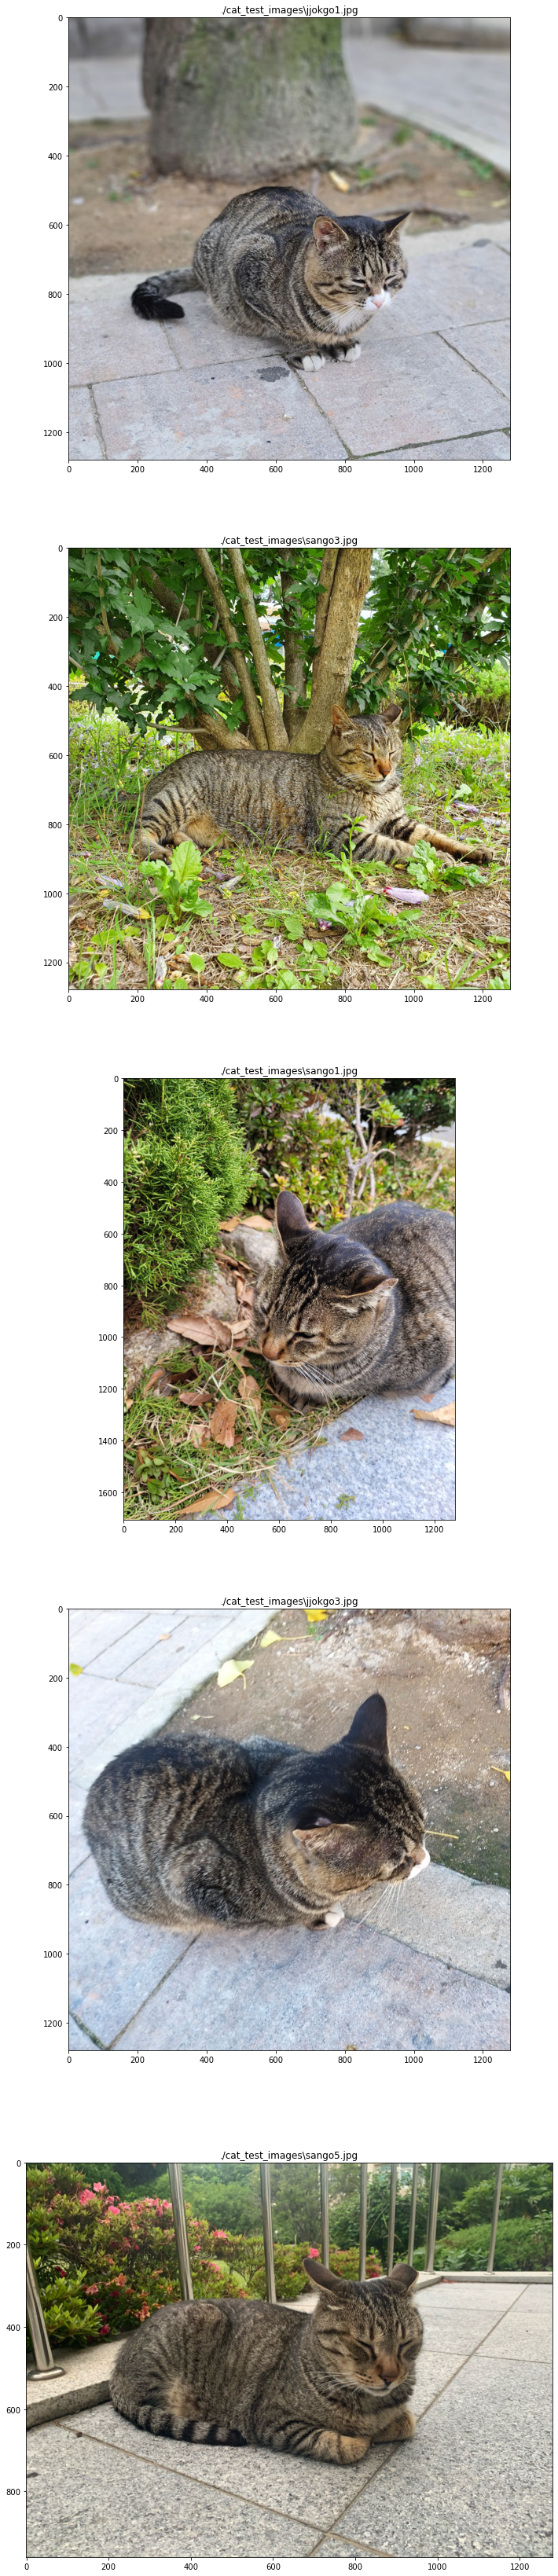

In [25]:
result =  []

for filename in filenames2:
    result.append(extract_features(filename, m))
    

neighbors = NearestNeighbors(n_neighbors=5,
                            algorithm='brute',
                            metric='euclidean').fit(result)

fig = plt.figure(figsize=(12, 60))
test_num = 0
j = 1

for i in neighbors.kneighbors([result[test_num]], return_distance=False)[0]:
    ax = fig.add_subplot(5, 1, j)
    j += 1
#     print(filenames2[i])
    ax.set_title(filenames2[i])
    plt_img = mpimg.imread(filenames2[i])
    imgplot = plt.imshow(plt_img)
#     display(Image(filename=filenames2[i]))
    plt.imshow(mpimg.imread(filenames2[i]))